# VoxCeleb trainer performance measures for pretrained ResNet34 on different type of audio signals

**Src**: https://github.com/clovaai/voxceleb_trainer

In [9]:
from google.colab import drive

ROOT = '/content/drive'

drive.mount(ROOT)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [11]:
%cd '/content/drive/My Drive/Stage-Imaging/Signal-denoising-in-the-wild/SpeakerRecognition'

/content/drive/My Drive/Stage-Imaging/Signal-denoising-in-the-wild/SpeakerRecognition


In [12]:
!pip install -q torchaudio

In [13]:
import sys, time, os, argparse, socket, random
import numpy as np
import pdb
import torch
import glob
from tuneThreshold import tuneThresholdfromScore
from SpeakerNet import SpeakerNet
from DatasetLoader import DatasetLoader
from utils import add_noise
import librosa
from DWaveNet import DWaveNet
import matplotlib.pyplot as plt
import seaborn as sns

# Default parameters
## Data loader
* parser.add_argument('--max_frames', type=int, default=200,  help='Input length to the network');
* parser.add_argument('--batch_size', type=int, default=200,  help='Batch size');
* parser.add_argument('--max_seg_per_spk', type=int, default=100, help='Maximum number of utterances per speaker per epoch');
* parser.add_argument('--nDataLoaderThread', type=int, default=5, help='Number of loader threads');

## Training details
* parser.add_argument('--test_interval', type=int, default=10, help='Test and save every [test_interval] epochs');
* parser.add_argument('--max_epoch',      type=int, default=500, help='Maximum number of epochs');
* parser.add_argument('--trainfunc', type=str, default="",    help='Loss function');
* parser.add_argument('--optimizer', type=str, default="adam", help='sgd or adam');

## Learning rates
* parser.add_argument('--lr', type=float, default=0.001,      help='Learning rate');
* parser.add_argument("--lr_decay", type=float, default=0.95, help='Learning rate decay every [test_interval] epochs');

## Loss functions
* parser.add_argument("--hard_prob", type=float, default=0.5, help='Hard negative mining probability, otherwise random, only for some loss functions');
* parser.add_argument("--hard_rank", type=int, default=10,    help='Hard negative mining rank in the batch, only for some loss functions');
* parser.add_argument('--margin', type=float,  default=1,     help='Loss margin, only for some loss functions');
* parser.add_argument('--scale', type=float,   default=15,    help='Loss scale, only for some loss functions');
* parser.add_argument('--nSpeakers', type=int, default=5994,  help='Number of speakers in the softmax layer for softmax-based losses, utterances per speaker per iteration for other losses');

## Load and save
* parser.add_argument('--initial_model',  type=str, default="", help='Initial model weights');
* parser.add_argument('--save_path',      type=str, default="./data/exp1", help='Path for model and logs');

## Training and test data
* parser.add_argument('--train_list', type=str, default="",   help='Train list');
* parser.add_argument('--test_list',  type=str, default="",   help='Evaluation list');
* parser.add_argument('--train_path', type=str, default="voxceleb2", help='Absolute path to the train set');
* parser.add_argument('--test_path',  type=str, default="voxceleb1", help='Absolute path to the test set');

## For test only
* parser.add_argument('--eval', dest='eval', action='store_true', help='Eval only')

## Model definition
* parser.add_argument('--model', type=str,        default="",     help='Name of model definition');
* parser.add_argument('--encoder_type', type=str, default="SAP",  help='Type of encoder');
* parser.add_argument('--nOut', type=int,         default=512,    help='Embedding size in the last FC layer');

# Tuned parameters from the repo author
* -- model "ResNetSE34L"
* -- trainfunc "angleproto"
* -- max_frames = 300
* -- save_path
* -- test_list
* -- test_path
* -- initial_model "baseline_lite_ap.model"

# Init pretrained model

In [ ]:
# params
eval = True
model = 'ResNetSE34L'
trainfunc = 'angleproto'
save_path = '/content/drive/My Drive/Stage-Imaging/'
max_frames = 300
batch_size = 200
max_seg_per_spk = 100
nDataLoaderThread = 5
max_epoch = 500
optimizer = 'adam'
hard_prob = .5
hard_rank = 10
margin = 1
scale = 15
nSpeakers = 5994
test_list = '/content/drive/My Drive/Stage-Imaging/Signal-denoising-in-the-wild/SpeakerRecognition/veri_test/veri_test.txt'
test_list_25 = '/content/drive/My Drive/Stage-Imaging/Signal-denoising-in-the-wild/SpeakerRecognition/veri_test/veri_test_2.5.txt'
test_list_25_denoised = '/content/drive/My Drive/Stage-Imaging/Signal-denoising-in-the-wild/SpeakerRecognition/veri_test/veri_test_2.5_denoised.txt'
test_list_75 = '/content/drive/My Drive/Stage-Imaging/Signal-denoising-in-the-wild/SpeakerRecognition/veri_test/veri_test_7.5.txt'
test_list_75_denoised = '/content/drive/My Drive/Stage-Imaging/Signal-denoising-in-the-wild/SpeakerRecognition/veri_test/veri_test_7.5_denoised.txt'
test_list_125 = '/content/drive/My Drive/Stage-Imaging/Signal-denoising-in-the-wild/SpeakerRecognition/veri_test/veri_test_12.5.txt'
test_list_125_denoised = '/content/drive/My Drive/Stage-Imaging/Signal-denoising-in-the-wild/SpeakerRecognition/veri_test/veri_test_12.5_denoised.txt'
test_list_175 = '/content/drive/My Drive/Stage-Imaging/Signal-denoising-in-the-wild/SpeakerRecognition/veri_test/veri_test_17.5.txt'
test_list_175_denoised = '/content/drive/My Drive/Stage-Imaging/Signal-denoising-in-the-wild/SpeakerRecognition/veri_test/veri_test_17.5_denoised.txt'
test_path = '/content/drive/My Drive/Datasets/VoxCeleb1_test/wav/'
initial_model = 'baseline_lite_ap.model'
encoder_type = 'SAP'
nOut = 512
lr = 0.001


# defaults
lr_decay = .95
test_interval = 10

In [ ]:
s = SpeakerNet(model = model, trainfunc = trainfunc, max_frames = max_frames, batch_size = batch_size, max_seg_per_spk = max_seg_per_spk, nDataLoaderThread = nDataLoaderThread, encoder_type = encoder_type, nOut = nOut,
               test_interval = test_interval, max_epoch = max_epoch, optimizer = optimizer, lr = lr, lr_decay = lr_decay, hard_prob = hard_prob, hard_rank = hard_rank, margin = margin, scale = scale,
               nSpeakers = nSpeakers)

it = 1
prevloss = float("inf")
sumloss = 0

Embedding size is 512, encoder SAP.
Initialised AngleProto


**Evaluation measure EER**:
* Normal audio &rarr; **2.2322**
* Noisy audio SNR 2.5 &rarr; **12.7094** - **16.5217**
* Noisy audio SNR 7.5 &rarr; **6.8452** - **10.8908**
* Noisy audio SNR 12.5 &rarr; **4.1304** - **8.4199**
* Noisy audio SNR 17.5 &rarr; **3.0170** - **7.1527**

In [ ]:
values = [2.23, 12.70, 6.84, 4.13, 3.01, 0.0, 16.52, 10.89, 8.41, 7.15]
type_of_audio = ['clean', 'snr 2.5', 'snr 7.5', 'snr 12.5', 'snr 17.5', 'clean', 'snr 2.5', 'snr 7.5', 'snr 12.5', 'snr 17.5']
denoised_or_not = ['pure','pure','pure','pure','pure','denoised','denoised','denoised','denoised','denoised']
#dos = [0.0, 16.52, 10.89, 8.41, 7.15]

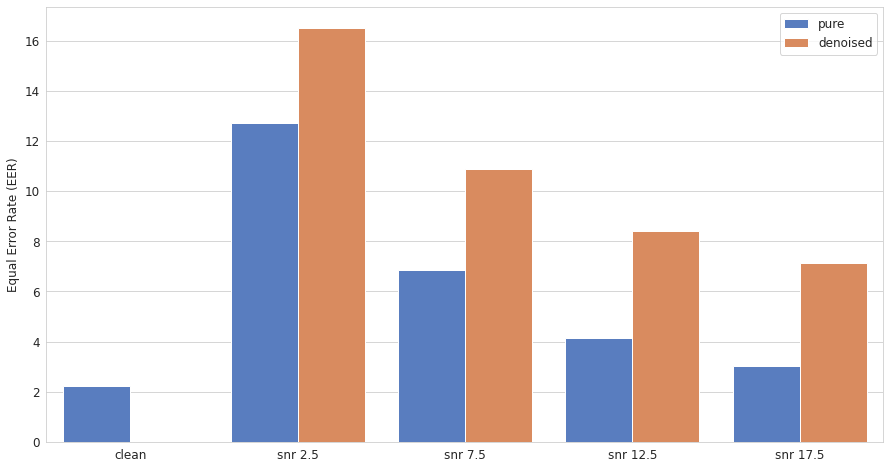

In [ ]:
plt.figure(figsize = (15, 8))
sns.set_style('whitegrid')
sns.barplot(x = np.array(type_of_audio), y = np.array(values), hue = np.array(denoised_or_not), palette = 'muted')
plt.ylabel('Equal Error Rate (EER)', fontdict = {'fontsize':12})
plt.yticks(size = 12)
plt.xticks(size = 12)
plt.legend(fontsize = 12)
#plt.savefig('../plots/SpeakerVerificationPerformance.png')

# Measures on test data

In [ ]:
## Load model weights
modelfiles = glob.glob('%s/model0*.model'%save_path)
modelfiles.sort()

if len(modelfiles) >= 1:
    s.loadParameters(modelfiles[-1]);
    print("Model %s loaded from previous state!"%modelfiles[-1]);
    it = int(os.path.splitext(os.path.basename(modelfiles[-1]))[0][5:]) + 1
elif(initial_model != ""):
    s.loadParameters(initial_model);
    print("Model %s loaded!"%initial_model);

for ii in range(0, it-1):
    if ii % test_interval == 0:
        clr = s.updateLearningRate(lr_decay)

Model baseline_lite_ap.model loaded!


## Normal audio

In [ ]:
if eval == True:   
  sc, lab = s.evaluateFromListSave(test_list, print_interval=100, test_path=test_path)
  result = tuneThresholdfromScore(sc, lab, [1, 0.1]);
  print('EER %2.4f'%result[1])

Reading 4700: 1.31 Hz, embed size 512
Computing 37700: 1925.20 Hz

EER 2.2322


## Noisy audio SNR 2.5

In [ ]:
%cd '/content/drive/My Drive/Stage-Imaging/Signal-denoising-in-the-wild/SpeakerRecognition'

/content/drive/My Drive/Stage-Imaging/Signal-denoising-in-the-wild/SpeakerRecognition


In [ ]:
main_path = '/content/drive/My Drive/Datasets/VoxCeleb1_test/wav'
noise_choice = {'music':659, 'noise':929, 'speech':425}
sample_rate = 16000
snr = 2.5

start = time.time()
with open('noise_logfile_snr2.5.txt', 'w') as f:
  print('Making noisy audio with SNR: {}'.format(snr))
  count = 1
  for folder in os.listdir(main_path):
    print('Making audio files for {}'.format(folder))
    for video in os.listdir(os.path.join(main_path, folder)):
      for file in os.listdir(os.path.join(main_path, folder, video)):
        if os.path.isfile(os.path.join(main_path, folder, video, file)):
          if not any(substring in file for substring in ["_2.5.", "_7.5.", "_12.5.", "_17.5."]):
            noise_type = random.choice(['music', 'noise', 'speech'])
            noise_track = np.random.randint(0, noise_choice[noise_type])
            _, noise_path = open('../data/musan_{}.scp'.format(noise_type)).readlines()[noise_track].rstrip().split()
            noise_path = noise_path.replace('/export/corpora/', '/content/drive/My Drive/Datasets/')
            noise_audio, _ = librosa.load(noise_path, sr = sample_rate)
            clean_audio, _ = librosa.load(os.path.join(main_path, folder, video, file), sr = sample_rate)
            filename = file.strip('.wav')
            filename = filename+'_'+str(snr)+'.wav'
            noisy_audio = add_noise(clean_audio, noise_audio, snr = snr)
            output_path = os.path.join(main_path, folder, video, filename)
            f.write('{} {}_{}\n'.format(output_path, noise_type, noise_track))
            librosa.output.write_wav(output_path, noisy_audio, sr = sample_rate)
            count += 1
      #print(clean_audio.shape, noise_path, noise_audio.shape, output_path)
  #break
end = time.time()
print('Made {} noisy audios in {} minutes'.format(count, (end-start)/60))

Making noisy audio with SNR: 2.5
Making audio files for id10280
Making audio files for id10279
Making audio files for id10308
Making audio files for id10276
Making audio files for id10275
Making audio files for id10309
Making audio files for id10274
Making audio files for id10307
Making audio files for id10273
Making audio files for id10272
Making audio files for id10306
Making audio files for id10305
Making audio files for id10284
Making audio files for id10304
Making audio files for id10303
Making audio files for id10278
Making audio files for id10271
Making audio files for id10302
Making audio files for id10301
Making audio files for id10300
Making audio files for id10298
Making audio files for id10297
Making audio files for id10296
Making audio files for id10295
Making audio files for id10294
Making audio files for id10292
Making audio files for id10290
Making audio files for id10287
Making audio files for id10286
Making audio files for id10285
Making audio files for id10283
Making

In [ ]:
with open('veri_test_2.5.txt', 'w') as f:
  for line in open('veri_test.txt'):
    files = line.split()
    files[1] = files[1].replace('.wav', '_2.5.wav')
    files[2] = files[2].replace('.wav', '_2.5.wav')
    f.write('{} {} {}\n'.format(files[0], files[1], files[2]))

print('Wrote txt file...')

In [ ]:
if eval == True:   
  sc, lab = s.evaluateFromListSave(test_list_25, print_interval=100, test_path=test_path)
  result = tuneThresholdfromScore(sc, lab, [1, 0.1]);
  print('EER %2.4f'%result[1])

Reading 4700: 6.66 Hz, embed size 512
Computing 37700: 1906.67 Hz

EER 12.7094


## Noisy audio SNR 7.5

In [ ]:
%cd '/content/drive/My Drive/Stage-Imaging/Signal-denoising-in-the-wild/SpeakerRecognition'

/content/drive/My Drive/Stage-Imaging/Signal-denoising-in-the-wild/SpeakerRecognition


In [ ]:
main_path = '/content/drive/My Drive/Datasets/VoxCeleb1_test/wav'
noise_choice = {'music':659, 'noise':929, 'speech':425}
sample_rate = 16000
snr = 7.5

start = time.time()
with open('noise_logfile_snr7.5.txt', 'w') as f:
  print('Making noisy audio with SNR: {}'.format(snr))
  count = 1
  for folder in os.listdir(main_path):
    print('Making audio files for {}'.format(folder))
    for video in os.listdir(os.path.join(main_path, folder)):
      for file in os.listdir(os.path.join(main_path, folder, video)):
        if os.path.isfile(os.path.join(main_path, folder, video, file)):
          if not any(substring in file for substring in ["_2.5.", "_7.5.", "_12.5.", "_17.5."]):
            noise_type = random.choice(['music', 'noise', 'speech'])
            noise_track = np.random.randint(0, noise_choice[noise_type])
            _, noise_path = open('../data/musan_{}.scp'.format(noise_type)).readlines()[noise_track].rstrip().split()
            noise_path = noise_path.replace('/export/corpora/', '/content/drive/My Drive/Datasets/')
            noise_audio, _ = librosa.load(noise_path, sr = sample_rate)
            clean_audio, _ = librosa.load(os.path.join(main_path, folder, video, file), sr = sample_rate)
            filename = file.strip('.wav')
            filename = filename+'_'+str(snr)+'.wav'
            noisy_audio = add_noise(clean_audio, noise_audio, snr = snr)
            output_path = os.path.join(main_path, folder, video, filename)
            f.write('{} {}_{}\n'.format(output_path, noise_type, noise_track))
            librosa.output.write_wav(output_path, noisy_audio, sr = sample_rate)
            count += 1
      #print(clean_audio.shape, noise_path, noise_audio.shape, output_path)
  #break
end = time.time()
print('Made {} noisy audios in {} minutes'.format(count, (end-start)/60))

Making noisy audio with SNR: 7.5
Making audio files for id10280
Making audio files for id10279
Making audio files for id10308
Making audio files for id10276
Making audio files for id10275
Making audio files for id10309
Making audio files for id10274
Making audio files for id10307
Making audio files for id10273
Making audio files for id10272
Making audio files for id10306
Making audio files for id10305
Making audio files for id10284
Making audio files for id10304
Making audio files for id10303
Making audio files for id10278
Making audio files for id10271
Making audio files for id10302
Making audio files for id10301
Making audio files for id10300
Making audio files for id10298
Making audio files for id10297
Making audio files for id10296
Making audio files for id10295
Making audio files for id10294
Making audio files for id10292
Making audio files for id10290
Making audio files for id10287
Making audio files for id10286
Making audio files for id10285
Making audio files for id10283
Making

In [ ]:
with open('veri_test_7.5.txt', 'w') as f:
  for line in open('veri_test.txt'):
    files = line.split()
    files[1] = files[1].replace('.wav', '_7.5.wav')
    files[2] = files[2].replace('.wav', '_7.5.wav')
    f.write('{} {} {}\n'.format(files[0], files[1], files[2]))

print('Wrote txt file...')

Wrote txt file...


In [ ]:
if eval == True:   
  sc, lab = s.evaluateFromListSave(test_list_75, print_interval=100, test_path=test_path)
  result = tuneThresholdfromScore(sc, lab, [1, 0.1]);
  print('EER %2.4f'%result[1])

Reading 4700: 3.24 Hz, embed size 512
Computing 37700: 1843.11 Hz

EER 6.8452


## Noisy audio SNR 12.5

In [ ]:
main_path = '/content/drive/My Drive/Datasets/VoxCeleb1_test/wav'
noise_choice = {'music':659, 'noise':929, 'speech':425}
sample_rate = 16000
snr = 12.5

start = time.time()
with open('noise_logfile_snr12.5.txt', 'w') as f:
  print('Making noisy audio with SNR: {}'.format(snr))
  count = 1
  for folder in os.listdir(main_path):
    print('Making audio files for {}'.format(folder))
    for video in os.listdir(os.path.join(main_path, folder)):
      for file in os.listdir(os.path.join(main_path, folder, video)):
        if os.path.isfile(os.path.join(main_path, folder, video, file)):
          if not any(substring in file for substring in ["_2.5.", "_7.5.", "_12.5.", "_17.5."]):
            noise_type = random.choice(['music', 'noise', 'speech'])
            noise_track = np.random.randint(0, noise_choice[noise_type])
            _, noise_path = open('../data/musan_{}.scp'.format(noise_type)).readlines()[noise_track].rstrip().split()
            noise_path = noise_path.replace('/export/corpora/', '/content/drive/My Drive/Datasets/')
            noise_audio, _ = librosa.load(noise_path, sr = sample_rate)
            clean_audio, _ = librosa.load(os.path.join(main_path, folder, video, file), sr = sample_rate)
            filename = file.strip('.wav')
            filename = filename+'_'+str(snr)+'.wav'
            noisy_audio = add_noise(clean_audio, noise_audio, snr = snr)
            output_path = os.path.join(main_path, folder, video, filename)
            f.write('{} {}_{}\n'.format(output_path, noise_type, noise_track))
            librosa.output.write_wav(output_path, noisy_audio, sr = sample_rate)
            count += 1
      #print(clean_audio.shape, noise_path, noise_audio.shape, output_path)
  #break
end = time.time()
print('Made {} noisy audios in {} minutes'.format(count, (end-start)/60))

Making noisy audio with SNR: 12.5
Making audio files for id10280
Making audio files for id10279
Making audio files for id10308
Making audio files for id10276
Making audio files for id10275
Making audio files for id10309
Making audio files for id10274
Making audio files for id10307
Making audio files for id10273
Making audio files for id10272
Making audio files for id10306
Making audio files for id10305
Making audio files for id10284
Making audio files for id10304
Making audio files for id10303
Making audio files for id10278
Making audio files for id10271
Making audio files for id10302
Making audio files for id10301
Making audio files for id10300
Making audio files for id10298
Making audio files for id10297
Making audio files for id10296
Making audio files for id10295
Making audio files for id10294
Making audio files for id10292
Making audio files for id10290
Making audio files for id10287
Making audio files for id10286
Making audio files for id10285
Making audio files for id10283
Makin

In [ ]:
with open('veri_test_12.5.txt', 'w') as f:
  for line in open('veri_test.txt'):
    files = line.split()
    files[1] = files[1].replace('.wav', '_12.5.wav')
    files[2] = files[2].replace('.wav', '_12.5.wav')
    f.write('{} {} {}\n'.format(files[0], files[1], files[2]))

print('Wrote txt file...')

Wrote txt file...


In [ ]:
if eval == True:   
  sc, lab = s.evaluateFromListSave(test_list_125, print_interval=100, test_path=test_path)
  result = tuneThresholdfromScore(sc, lab, [1, 0.1]);
  print('EER %2.4f'%result[1])

Reading 4700: 2.03 Hz, embed size 512
Computing 37700: 3091.02 Hz

EER 4.1304


## Noisy audio SNR 17.5

In [ ]:
main_path = '/content/drive/My Drive/Datasets/VoxCeleb1_test/wav'
noise_choice = {'music':659, 'noise':929, 'speech':425}
sample_rate = 16000
snr = 17.5

start = time.time()
with open('noise_logfile_snr17.5.txt', 'w') as f:
  print('Making noisy audio with SNR: {}'.format(snr))
  count = 1
  for folder in os.listdir(main_path):
    print('Making audio files for {}'.format(folder))
    for video in os.listdir(os.path.join(main_path, folder)):
      for file in os.listdir(os.path.join(main_path, folder, video)):
        if os.path.isfile(os.path.join(main_path, folder, video, file)):
          if not any(substring in file for substring in ["_2.5.", "_7.5.", "_12.5.", "_17.5."]):
            noise_type = random.choice(['music', 'noise', 'speech'])
            noise_track = np.random.randint(0, noise_choice[noise_type])
            _, noise_path = open('../data/musan_{}.scp'.format(noise_type)).readlines()[noise_track].rstrip().split()
            noise_path = noise_path.replace('/export/corpora/', '/content/drive/My Drive/Datasets/')
            noise_audio, _ = librosa.load(noise_path, sr = sample_rate)
            clean_audio, _ = librosa.load(os.path.join(main_path, folder, video, file), sr = sample_rate)
            filename = file.strip('.wav')
            filename = filename+'_'+str(snr)+'.wav'
            noisy_audio = add_noise(clean_audio, noise_audio, snr = snr)
            output_path = os.path.join(main_path, folder, video, filename)
            f.write('{} {}_{}\n'.format(output_path, noise_type, noise_track))
            librosa.output.write_wav(output_path, noisy_audio, sr = sample_rate)
            count += 1
      #print(clean_audio.shape, noise_path, noise_audio.shape, output_path)
  #break
end = time.time()
print('Made {} noisy audios in {} minutes'.format(count, (end-start)/60))

Making noisy audio with SNR: 17.5
Making audio files for id10280
Making audio files for id10279
Making audio files for id10308
Making audio files for id10276
Making audio files for id10275
Making audio files for id10309
Making audio files for id10274
Making audio files for id10307
Making audio files for id10273
Making audio files for id10272
Making audio files for id10306
Making audio files for id10305
Making audio files for id10284
Making audio files for id10304
Making audio files for id10303
Making audio files for id10278
Making audio files for id10271
Making audio files for id10302
Making audio files for id10301
Making audio files for id10300
Making audio files for id10298
Making audio files for id10297
Making audio files for id10296
Making audio files for id10295
Making audio files for id10294
Making audio files for id10292
Making audio files for id10290
Making audio files for id10287
Making audio files for id10286
Making audio files for id10285
Making audio files for id10283
Makin

In [ ]:
with open('veri_test_17.5.txt', 'w') as f:
  for line in open('veri_test.txt'):
    files = line.split()
    files[1] = files[1].replace('.wav', '_17.5.wav')
    files[2] = files[2].replace('.wav', '_17.5.wav')
    f.write('{} {} {}\n'.format(files[0], files[1], files[2]))

print('Wrote txt file...')

Wrote txt file...


In [ ]:
if eval == True:   
  sc, lab = s.evaluateFromListSave(test_list_175, print_interval=100, test_path=test_path)
  result = tuneThresholdfromScore(sc, lab, [1, 0.1]);
  print('EER %2.4f'%result[1])

Reading 4700: 1.33 Hz, embed size 512
Computing 37700: 1943.36 Hz

EER 3.0170


### Concat noise logfiles

'/content/drive/My Drive/Stage-Imaging/Signal-denoising-in-the-wild/SpeakerRecognition'

In [16]:
filenames = ['noise_logfile_snr2.5.txt', 'noise_logfile_snr7.5.txt', 'noise_logfile_snr12.5.txt', 'noise_logfile_snr17.5.txt']
with open('logfiles/noise_logfile.txt', 'w') as outfile:
    for fname in filenames:
        with open('logfiles/'+fname) as infile:
            for line in infile:
                outfile.write(line)

print('Wrote noise logfile..')

Wrote noise logfile..


## Denoised audio

### WaveNet

In [ ]:
main_path = '/content/drive/My Drive/Datasets/VoxCeleb1_test/wav'
for folder in os.listdir(main_path):
  for video in os.listdir(os.path.join(main_path, folder)):
    if os.path.isdir(os.path.join(main_path, folder, video, 'denoised')):
      pass
    else:
      os.mkdir(os.path.join(main_path, folder, video, 'denoised'))

print('Made subdirs...')

Made subdirs...


In [ ]:
model = DWaveNet(in_channels = 1, num_layers = 30,
                 num_stacks = 3, residual_channels = 128,
                 gate_channels = 128, skip_out_channels = 128,
                 last_channels=(1024, 256))

In [ ]:
pretrain_model_pth = "../log/denoising/wavenet/model_best.pth.tar"

if pretrain_model_pth is not None:
    if os.path.isfile(pretrain_model_pth):
        print('loading pre-trained model from %s' % pretrain_model_pth)
        model_dict = model.state_dict()
        checkpoint = torch.load(pretrain_model_pth, map_location = lambda storage, loc: storage) # load for cpu
        model.load_state_dict({k.replace('module.',''):v for k,v in checkpoint['state_dict'].items()})
    else:
        print("===> no checkpoint found at '{}'".format(pretrain_model_pth))

loading pre-trained model from ../log/denoising/wavenet/model_best.pth.tar


In [ ]:
# to_exclude = ['id10280', 'id10279', 'id10308', 'id10276', 'id10275', 'id10309', 'id10274',
#               'id10307', 'id10273', 'id10272', 'id10306', 'id10305', 'id10284', 'id10304',
#               'id10303', 'id10278', 'id10271', 'id10302', 'id10301', 'id10300', 'id10298',
#               'id10297', 'id10296', 'id10295', 'id10294', 'id10292', 'id10290', 'id10287',
#               'id10286', 'id10285']

In [ ]:
main_path = '/content/drive/My Drive/Datasets/VoxCeleb1_test/wav'

snr = 17.5
sample_rate = 16000
model = model.cuda()
model = model.eval()

count = 0
start = time.time()
for folder in os.listdir(main_path):
#  if folder not in to_exclude:
  print('Denoising audio files for {}'.format(folder))
  for video in os.listdir(os.path.join(main_path, folder)):
    for file in os.listdir(os.path.join(main_path, folder, video)):
      if os.path.isfile(os.path.join(main_path, folder, video, file)):
        if "_"+str(snr)+"." in file:
          noisy_audio, _ = librosa.load(os.path.join(main_path, folder, video, file), sr = sample_rate)
          noisy_audio = torch.FloatTensor(noisy_audio).unsqueeze(0).unsqueeze(0).cuda()
          with torch.no_grad():
            denoised_audio = model(noisy_audio)
          denoised_audio = denoised_audio.squeeze(0).squeeze(0).cpu().numpy()
          output_path = os.path.join(main_path, folder, video, file[:-14], 'denoised', file[-14:])
          librosa.output.write_wav(output_path, denoised_audio, sr = sample_rate)
          count += 1

end = time.time()
print('Made {} denoised audios in {:.2f} min'.format(count, (end-start)/60))

Denoising audio files for id10280
Denoising audio files for id10279
Denoising audio files for id10308
Denoising audio files for id10276
Denoising audio files for id10275
Denoising audio files for id10309
Denoising audio files for id10274
Denoising audio files for id10307
Denoising audio files for id10273
Denoising audio files for id10272
Denoising audio files for id10306
Denoising audio files for id10305
Denoising audio files for id10284
Denoising audio files for id10304
Denoising audio files for id10303
Denoising audio files for id10278
Denoising audio files for id10271
Denoising audio files for id10302
Denoising audio files for id10301
Denoising audio files for id10300
Denoising audio files for id10298
Denoising audio files for id10297
Denoising audio files for id10296
Denoising audio files for id10295
Denoising audio files for id10294
Denoising audio files for id10292
Denoising audio files for id10290
Denoising audio files for id10287
Denoising audio files for id10286
Denoising audi

In [ ]:
with open('veri_test/veri_test_17.5_denoised.txt', 'w') as f:
  for line in open('veri_test/veri_test_2.5_denoised.txt'):
    files = line.split()
    files[1] = files[1].replace('_2.5.', '_17.5.')
    files[2] = files[2].replace('_2.5.', '_17.5.')
    f.write('{} {} {}\n'.format(files[0], files[1], files[2]))

print('Wrote txt file...')

Wrote txt file...


In [ ]:
if eval == True:   
  sc, lab = s.evaluateFromListSave(test_list_175_denoised, print_interval=100, test_path=test_path)
  result = tuneThresholdfromScore(sc, lab, [1, 0.1]);
  print('EER %2.4f'%result[1])

Reading 1300: 1.46 Hz, embed size 512

KeyboardInterrupt: ignored

<hr>

In [ ]:
!pip install -q kaldi_io
!pip install -q kaldiio

In [ ]:
from datasets import SequenceDataset
from torch.utils.data import DataLoader


################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [ ]:
train_dataset = SequenceDataset('../data/train/trainColab.scp', '../data/utt2spk.scp', min_length = 16000, colab = True)
train_data = DataLoader(train_dataset, batch_size = 8, shuffle=True)

Totally 7344 samples with at most 247 samples for one class


In [ ]:
clean, dirty, _ = next(iter(train_data))

In [ ]:
clean, dirty = clean[0], dirty[0]

In [ ]:
import IPython.display as ipd

In [ ]:
ipd.Audio(clean.squeeze().numpy(), rate = 16000)

In [ ]:
ipd.Audio(dirty.squeeze().numpy(), rate = 16000)

In [ ]:
clean, dirty = clean.cuda(), dirty.cuda()

In [ ]:
model = s.__S__

In [ ]:
from torchsummary import summary

In [ ]:
with torch.no_grad():
  clean_vector = model(clean)

In [ ]:
with torch.no_grad():
  dirty_vector = model(dirty)

In [ ]:
torch.nn.L1Loss(reduction = 'sum')(clean_vector, dirty_vector)

tensor(45.5057, device='cuda:0')

In [ ]:
audio = torch.rand((1, 32000))

torch.Size([1, 32000])

In [ ]:
output = model(audio.cuda())

In [ ]:
output.size()

torch.Size([1, 512])

tensor([[-1.4256e-01, -7.8243e-02, -1.7222e-01,  8.1785e-02,  2.3823e-01,
         -2.7237e-01,  2.8715e-01,  3.2382e-01,  5.4686e-02,  1.3072e-01,
          8.5216e-02,  9.4126e-02, -1.3536e-01, -8.5353e-02, -9.3708e-03,
         -5.1751e-03,  1.5880e-01, -2.6842e-01, -2.6914e-02,  5.7501e-02,
          2.0690e-01, -3.4521e-02,  1.7746e-01,  6.0815e-02, -7.7710e-02,
         -3.9758e-01, -1.6967e-01, -3.7067e-02,  3.1042e-01,  1.6891e-01,
         -5.5867e-01, -4.6217e-02,  2.6051e-02,  1.2398e-01,  1.9629e-01,
         -4.2654e-01,  9.8750e-02,  2.4299e-02,  1.7963e-01,  1.9071e-01,
          3.8421e-01, -2.0169e-02, -1.1670e-01,  1.5613e-01,  2.9781e-01,
          2.2713e-01, -5.3553e-02,  2.4448e-01, -2.0633e-01,  1.8603e-01,
          2.7623e-01, -1.0419e-02,  1.7173e-02,  2.7252e-01,  1.2422e-01,
          1.0038e-01,  6.1567e-02,  4.0433e-02,  2.5155e-01, -3.2197e-01,
         -3.0420e-01, -7.5774e-02,  1.2705e-01, -2.9772e-01,  5.2032e-02,
          4.7842e-03,  9.4582e-02,  1.

In [ ]:
s.__S__.forward()

TypeError: ignored

In [ ]:
from sklearn import metrics

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(lab, sc, pos_label = 1)

In [ ]:
fnr = 1-tpr
fnr = fnr*100
fpr = fpr*100

In [ ]:
np.nanargmin()

In [ ]:
tunedThreshold = []
for tfa in [1, 0.1]:
        idx = np.nanargmin(np.absolute((tfa - fpr))) # numpy.where(fpr<=tfa)[0][-1]
        tunedThreshold.append([thresholds[idx], fpr[idx], fnr[idx]])
    
# idxE = numpy.nanargmin(numpy.absolute((fnr - fpr)))
# eer  = max(fpr[idxE],fnr[idxE])
    


In [ ]:
tunedThreshold

[[-0.9160937666893005, 1.0021208907741253, 29.570519618239665],
 [-0.8498210310935974, 0.10074231177094381, 55.99681866383881]]

In [ ]:
idxE = np.nanargmin(np.absolute((fnr - fpr)))

In [ ]:
idxE

2131

In [ ]:
fnr[idxE]

7.147401908801698

In [ ]:
import os
import glob
import sys
import time
from sklearn import metrics
import numpy
import pdb

def tuneThresholdfromScore(scores, labels, target_fa, target_fr = None):
    
    fpr, tpr, thresholds = metrics.roc_curve(labels, scores, pos_label=1)
    fnr = 1 - tpr
    
    fnr = fnr*100
    fpr = fpr*100

    tunedThreshold = [];
    if target_fr:
        for tfr in target_fr:
            idx = numpy.nanargmin(numpy.absolute((tfr - fnr)))
            tunedThreshold.append([thresholds[idx], fpr[idx], fnr[idx]]);
    
    for tfa in target_fa:
        idx = numpy.nanargmin(numpy.absolute((tfa - fpr))) # numpy.where(fpr<=tfa)[0][-1]
        tunedThreshold.append([thresholds[idx], fpr[idx], fnr[idx]]);
    
    idxE = numpy.nanargmin(numpy.absolute((fnr - fpr)))
    eer  = max(fpr[idxE],fnr[idxE])
    
    return (tunedThreshold, eer, fpr, fnr);

In [ ]:
audio, _ = librosa.load()

In [ ]:
s

SpeakerNet(
  (__S__): ResNetSE(
    (conv1): Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 1), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): SEBasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (se): SELayer(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (fc): Sequential(
            (0): Linear(in_features=16, out_features=2, bias=True)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=2, out_features=16, bias=True)
            (

In [ ]:
from torchsummary import summary

In [ ]:
summary(s.__S__, input_size = (32000,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       Spectrogram-1             [-1, 257, 201]               0
          MelScale-2              [-1, 40, 201]               0
    MelSpectrogram-3              [-1, 40, 201]               0
    InstanceNorm1d-4              [-1, 40, 201]               0
            Conv2d-5          [-1, 16, 20, 201]             784
       BatchNorm2d-6          [-1, 16, 20, 201]              32
              ReLU-7          [-1, 16, 20, 201]               0
            Conv2d-8          [-1, 16, 20, 201]           2,304
              ReLU-9          [-1, 16, 20, 201]               0
      BatchNorm2d-10          [-1, 16, 20, 201]              32
           Conv2d-11          [-1, 16, 20, 201]           2,304
      BatchNorm2d-12          [-1, 16, 20, 201]              32
AdaptiveAvgPool2d-13             [-1, 16, 1, 1]               0
           Linear-14                   